> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
>
>      http://www.apache.org/licenses/LICENSE-2.0
>
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS-IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

# Seasonal Gencast test notebook

This notebook explores using the Gencast mini 1 degree architecture for generating new ensemble members for Glosea6 seasonal forecasts. Enviroment used is the same as Gencast, with the modified Gencast library

In [1]:
%pip uninstall graphcast -y

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install dm-tree graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 811.9 kB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [30]:
%pip install ipdb

/opt/jaspy/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:

%pip install /home/users/achamber/gencast_seasonal/gencast_seasonal/

In [2]:
import dataclasses
import datetime
import math
import random
from glob import glob
from typing import Optional
import haiku as hk
from IPython.display import HTML
from IPython import display
import ipywidgets as widgets
import jax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import xarray

from gencast_seasonal import rollout
from gencast_seasonal import xarray_jax
from gencast_seasonal import normalization
from gencast_seasonal import checkpoint
from gencast_seasonal import data_utils
from gencast_seasonal import xarray_tree
from gencast_seasonal import gencast
from gencast_seasonal import denoiser
from gencast_seasonal import nan_cleaning

# Plotting functions


In [2]:

def select(
    data: xarray.Dataset,
    variable: str,
    level: Optional[int] = None,
    max_steps: Optional[int] = None
    ) -> xarray.Dataset:
  data = data[variable]
  if "batch" in data.dims:
    data = data.isel(batch=0)
  if max_steps is not None and "time" in data.sizes and max_steps < data.sizes["time"]:
    data = data.isel(time=range(0, max_steps))
  if level is not None and "level" in data.coords:
    data = data.sel(level=level)
  return data

def scale(
    data: xarray.Dataset,
    center: Optional[float] = None,
    robust: bool = False,
    ) -> tuple[xarray.Dataset, matplotlib.colors.Normalize, str]:
  vmin = np.nanpercentile(data, (2 if robust else 0))
  vmax = np.nanpercentile(data, (98 if robust else 100))
  if center is not None:
    diff = max(vmax - center, center - vmin)
    vmin = center - diff
    vmax = center + diff
  return (data, matplotlib.colors.Normalize(vmin, vmax),
          ("RdBu_r" if center is not None else "viridis"))

def plot_data(
    data: dict[str, xarray.Dataset],
    fig_title: str,
    plot_size: float = 5,
    robust: bool = False,
    cols: int = 4
    ) -> tuple[xarray.Dataset, matplotlib.colors.Normalize, str]:

  first_data = next(iter(data.values()))[0]
  max_steps = first_data.sizes.get("time", 1)
  assert all(max_steps == d.sizes.get("time", 1) for d, _, _ in data.values())

  cols = min(cols, len(data))
  rows = math.ceil(len(data) / cols)
  figure = plt.figure(figsize=(plot_size * 2 * cols,
                               plot_size * rows))
  figure.suptitle(fig_title, fontsize=16)
  figure.subplots_adjust(wspace=0, hspace=0)
  figure.tight_layout()

  images = []
  for i, (title, (plot_data, norm, cmap)) in enumerate(data.items()):
    ax = figure.add_subplot(rows, cols, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    im = ax.imshow(
        plot_data.isel(time=0, missing_dims="ignore"), norm=norm,
        origin="lower", cmap=cmap)
    plt.colorbar(
        mappable=im,
        ax=ax,
        orientation="vertical",
        pad=0.02,
        aspect=16,
        shrink=0.75,
        cmap=cmap,
        extend=("both" if robust else "neither"))
    images.append(im)

  def update(frame):
    if "time" in first_data.dims:
      td = datetime.timedelta(microseconds=first_data["time"][frame].item() / 1000)
      figure.suptitle(f"{fig_title}, {td}", fontsize=16)
    else:
      figure.suptitle(fig_title, fontsize=16)
    for im, (plot_data, norm, cmap) in zip(images, data.values()):
      im.set_data(plot_data.isel(time=frame, missing_dims="ignore"))

  ani = animation.FuncAnimation(
      fig=figure, func=update, frames=max_steps, interval=250)
  plt.close(figure.number)
  return HTML(ani.to_jshtml())


In [3]:
input_path = "/gws/pw/j07/climateresilience/MLdata"

Test various model param options using random weights

In [8]:

latent_value_options = [int(2**i) for i in range(4, 10)]
random_latent_size = widgets.Dropdown(
    options=latent_value_options, value=512,description="Latent size:")
random_attention_type = widgets.Dropdown(
    options=[ "triblockdiag_mha", "mha"], value="triblockdiag_mha", description="Attention:")
random_mesh_size = widgets.IntSlider(
    value=5, min=4, max=6, description="Mesh size:")
random_num_heads = widgets.Dropdown(
    options=[int(2**i) for i in range(0, 3)], value=4,description="Num heads:")
random_attention_k_hop = widgets.Dropdown(
    options=[int(2**i) for i in range(2, 5)], value=16,description="Attn k hop:")
random_resolution = "1p0"

def update_latent_options(*args):
  def _latent_valid_for_attn(attn, latent, heads):
    head_dim, rem = divmod(latent, heads)
    if rem != 0:
      return False
    # Required for splash attn.
    if head_dim % 128 != 0:
      return attn != "splash_mha"
    return True
  attn = random_attention_type.value
  heads = random_num_heads.value
  random_latent_size.options = [
      latent for latent in latent_value_options
      if _latent_valid_for_attn(attn, latent, heads)]

# Observe changes to only allow for valid combinations.
random_attention_type.observe(update_latent_options, "value")
random_latent_size.observe(update_latent_options, "value")
random_num_heads.observe(update_latent_options, "value")


source_tab = widgets.Tab([
    widgets.VBox([
        random_attention_type,
        random_mesh_size,
        random_num_heads,
        random_latent_size,
        random_attention_k_hop,
    ]),
])
source_tab.set_title(0, "Random")
widgets.VBox([
    source_tab,
    widgets.Label(value="Run the next cell to load the model. Rerunning this cell clears your selection.")
])

In [9]:
source = source_tab.get_title(source_tab.selected_index)

if source == "Random":
  params = None  # Filled in below
  state = {}
  task_config = gencast.TASK
  # Use default values.
  sampler_config = gencast.SamplerConfig()
  noise_config = gencast.NoiseConfig()
  noise_encoder_config = denoiser.NoiseEncoderConfig()
  # Configure, otherwise use default values.
  denoiser_architecture_config = denoiser.DenoiserArchitectureConfig(
    sparse_transformer_config = denoiser.SparseTransformerConfig(
        attention_k_hop=random_attention_k_hop.value,
        attention_type=random_attention_type.value,
        d_model=random_latent_size.value,
        num_heads=random_num_heads.value
        ),
    mesh_size=random_mesh_size.value,
    latent_size=random_latent_size.value,
  )

In [4]:
dataset_file_options = glob(input_path + "/glosea_600_slices/" + "source*")

dataset_file = widgets.Dropdown(
    options=[
        (option) for option in dataset_file_options
    ],
    description="Dataset file:",
    layout={"width": "max-content"})
widgets.VBox([
    dataset_file,
    widgets.Label(value="Run the next cell to load the dataset. Rerunning this cell clears your selection and refilters the datasets that match your model.")
])

In [5]:
example_batch = xarray.load_dataset(dataset_file.value,engine="netcdf4").compute()
file_path = dataset_file.value
print(dataset_file.value.removesuffix(".nc"))
example_batch


/gws/pw/j07/climateresilience/MLdata/glosea_600_slices/source-glosea600_date-19930109_levels-2_lead-3m


<xarray.Dataset> Size: 88MB
Dimensions:                    (number: 7, forecastMonth: 3, latitude: 180,
                                longitude: 360, level: 2)
Coordinates:
    time                       datetime64[ns] 8B 1993-01-09
  * forecastMonth              (forecastMonth) int64 24B 1 2 3
  * latitude                   (latitude) float64 1kB 89.5 88.5 ... -88.5 -89.5
  * longitude                  (longitude) float64 3kB 0.5 1.5 ... 358.5 359.5
  * number                     (number) int64 56B 0 1 2 3 4 5 6
  * level                      (level) float64 16B 500.0 850.0
Data variables: (12/13)
    10m_u_component_of_wind    (number, forecastMonth, latitude, longitude) float32 5MB ...
    10m_v_component_of_wind    (number, forecastMonth, latitude, longitude) float32 5MB ...
    2m_temperature             (number, forecastMonth, latitude, longitude) float32 5MB ...
    mean_sea_level_pressure    (number, forecastMonth, latitude, longitude) float32 5MB ...
    sea_surface_temperature    (number, forecastMonth, latitude, longitude) float32 5MB ...
    total_precipitation_month  (number, forecastMonth, latitude, longitude) float32 5MB ...
    ...                         ...
    specific_humidity          (forecastMonth, level, number, latitude, longitude) float32 11MB ...
    temperature                (forecastMonth, level, number, latitude, longitude) float32 11MB ...
    u_component_of_wind        (forecastMonth, level, number, latitude, longitude) float32 11MB ...
    v_component_of_wind        (forecastMonth, level, number, latitude, longitude) float32 11MB ...
    land_sea_mask              (latitude, longitude) float32 259kB 0.0 ... 1.0
    geopotential_at_surface    (latitude, longitude) float32 259kB -0.0009766...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_subCentre:          98
    Conventions:             CF-1.7
    institution:             U.K. Met Office - Exeter
    history:                 2025-02-04T11:38 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
plot_example_variable = widgets.Dropdown(
    options=example_batch.data_vars.keys(),
    value="2m_temperature",
    description="Variable")
plot_example_level = widgets.Dropdown(
    options=example_batch.coords["level"].values,
    value=500,
    description="Level")
plot_example_lead_time = widgets.IntSlider(
    min=1, max=example_batch.dims["forecastMonth"], value=example_batch.dims["forecastMonth"],
    description="Months lead time")

widgets.VBox([
    plot_example_variable,
    plot_example_level,
    plot_example_lead_time,
    widgets.Label(value="Run the next cell to plot the data. Rerunning this cell clears your selection.")
])

In [ ]:
# @title Plot example data

plot_size = 7

data = {
    " ": scale(select(example_batch, plot_example_variable.value, plot_example_level.value, plot_example_lead_time.value),
              ),
}
fig_title = plot_example_variable.value
if "level" in example_batch[plot_example_variable.value].coords:
  fig_title += f" at {plot_example_level.value} hPa"

plot_data(data, fig_title, plot_size)

In [7]:
task_config

TaskConfig(input_variables=('2m_temperature', 'mean_sea_level_pressure', '10m_v_component_of_wind', '10m_u_component_of_wind', 'total_precipitation_month', 'temperature', 'geopotential', 'u_component_of_wind', 'v_component_of_wind', 'year_progress_sin', 'year_progress_cos', 'geopotential_at_surface', 'land_sea_mask'), target_variables=('2m_temperature', 'mean_sea_level_pressure', '10m_v_component_of_wind', '10m_u_component_of_wind', 'total_precipitation_month', 'temperature', 'geopotential', 'u_component_of_wind', 'v_component_of_wind'), forcing_variables=('year_progress_sin', 'year_progress_cos'), pressure_levels=(500, 850), input_duration='24h')

In [6]:
def get_training_data(file_path,lead_time=1,n_models_total=3,batch_n=1,fixed=False,fixed_list=[0,1,2]):
    
    raw_training = xarray.load_dataset(file_path,engine="netcdf4").compute()
    raw_training.assign_coords(batch=[batch_n]) # remove datetime from batch
    dic = dataclasses.asdict(task_config)
    del dic["input_duration"] # easier than removing input_duration from the task config
    models_picked=n_models_total
    lead_time_list = [lead_time]*models_picked
    input_list = random.sample(range(0,raw_training.sizes["number"]),models_picked)
    if fixed == True:
        input_list = fixed_list
    
    train_inputs, train_targets, train_forcings = data_utils.extract_inputs_targets_forcings(
    raw_training, input_target_num=input_list,input_target_lead=lead_time_list, 
    **dic)
    
    train_inputs = train_inputs.isel(forecastMonth=0) # forecast month just repeated along len direction
    train_inputs = train_inputs.expand_dims("time").rename({"longitude":"lon","latitude":"lat","time":"batch"})
    train_targets = train_targets.expand_dims("time").rename({"longitude":"lon","latitude":"lat","time":"batch"})
    train_inputs = train_inputs.assign_coords(lat=train_inputs.lat.data[::-1])
    train_targets = train_targets.assign_coords(lat=train_targets.lat.data[::-1])
    train_inputs = train_inputs.assign_coords(lon=train_inputs.lon -.5)
    train_targets = train_targets.assign_coords(lon=train_targets.lon -.5)
    train_targets = train_targets.expand_dims("number")
    train_forcings = train_inputs[['year_progress_sin', 'year_progress_cos']]
    train_forcings = train_forcings.sel(number=input_list[0]).expand_dims("number").assign_coords(number=[input_list[-1]])

    ## set values of coords for optmisiation purposes - otherwise JAX gets 50x slower
    train_inputs = train_inputs.assign_coords(batch=[1])
    train_targets = train_targets.assign_coords(batch=[1])
    train_forcings = train_forcings.assign_coords(batch=[1])
    train_inputs = train_inputs.assign_coords(number=[0,1])
    train_targets = train_targets.assign_coords(number=[2])
    train_forcings = train_forcings.assign_coords(number=[2])    

    return train_inputs, train_targets, train_forcings

In [10]:
train_inputs, train_targets, train_forcings = get_training_data(file_path,fixed=True)

In [90]:
train_inputs = xarray.concat([train_inputs,train_inputs],dim="batch")
train_targets = xarray.concat([train_targets,train_targets],dim="batch")
train_forcings = xarray.concat([train_forcings,train_forcings],dim="batch")


In [9]:
train_inputs

<xarray.Dataset> Size: 7MB
Dimensions:                    (batch: 1, number: 2, lat: 180, lon: 360,
                                level: 2)
Coordinates:
    forecastMonth              int64 8B 1
  * level                      (level) float64 16B 500.0 850.0
  * lat                        (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                        (lon) float64 3kB 0.0 1.0 2.0 ... 358.0 359.0
  * batch                      (batch) int64 8B 1
  * number                     (number) int64 16B 0 1
Data variables: (12/13)
    2m_temperature             (batch, number, lat, lon) float32 518kB 240.9 ...
    mean_sea_level_pressure    (batch, number, lat, lon) float32 518kB 1.012e...
    10m_v_component_of_wind    (batch, number, lat, lon) float32 518kB 1.206 ...
    10m_u_component_of_wind    (batch, number, lat, lon) float32 518kB -2.317...
    total_precipitation_month  (batch, number, lat, lon) float32 518kB 3.434e...
    temperature                (batch, level, number, lat, lon) float32 1MB 2...
    ...                         ...
    u_component_of_wind        (batch, level, number, lat, lon) float32 1MB 2...
    v_component_of_wind        (batch, level, number, lat, lon) float32 1MB 3...
    year_progress_sin          (batch, number) float32 8B 0.1445 0.1445
    year_progress_cos          (batch, number) float32 8B 0.9895 0.9895
    geopotential_at_surface    (batch, lat, lon) float32 259kB -0.0009766 ......
    land_sea_mask              (batch, lat, lon) float32 259kB 0.0 0.0 ... 1.0
Attributes:
    GRIB_edition:            1
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_subCentre:          98
    Conventions:             CF-1.7
    institution:             U.K. Met Office - Exeter
    history:                 2025-02-04T11:38 GRIB to CDM+CF via cfgrib-0.9.1...

In [16]:
train_forcings.dims.mapping

{'number': 1, 'batch': 1}

In [17]:
train_forcings

<xarray.Dataset> Size: 32B
Dimensions:            (number: 1, batch: 1)
Coordinates:
  * batch              (batch) datetime64[ns] 8B 1993-01-09
    forecastMonth      int64 8B 1
  * number             (number) int64 8B 2
Data variables:
    year_progress_sin  (number, batch) float32 4B 0.1445
    year_progress_cos  (number, batch) float32 4B 0.9895
Attributes:
    GRIB_edition:            1
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_subCentre:          98
    Conventions:             CF-1.7
    institution:             U.K. Met Office - Exeter
    history:                 2025-02-04T11:38 GRIB to CDM+CF via cfgrib-0.9.1...

In [54]:
diffs_stddev_by_level = xarray.load_dataset(input_path+"/glosea_600_hc_stddev_by_level.nc").compute()
mean_by_level = xarray.load_dataset(input_path+"/glosea_600_hc_mean_by_level.nc").compute()
stddev_by_level = xarray.load_dataset(input_path+"/glosea_600_hc_stddev_by_level.nc").compute()
min_by_level = xarray.load_dataset(input_path+"/glosea_600_hc_mean_by_level.nc").compute()

In [42]:
mean_by_level = mean_by_level.rename({
    "u10":"10m_u_component_of_wind",
    "v10":"10m_v_component_of_wind",
    "t2m":"2m_temperature",
    "msl":"mean_sea_level_pressure",
    "sst":"sea_surface_temperature",
    "tprate":"total_precipitation_month",
    "z":"geopotential",
    "q":"specific_humidity",
    "t":"temperature",
    "u":"u_component_of_wind",
    "v":"v_component_of_wind" })

In [69]:
mean_by_level

<xarray.Dataset> Size: 4MB
Dimensions:                    (latitude: 180, longitude: 360, bnds: 2,
                                isobaricInhPa: 2)
Coordinates:
  * latitude                   (latitude) float64 1kB 89.5 88.5 ... -88.5 -89.5
  * longitude                  (longitude) float64 3kB 0.5 1.5 ... 358.5 359.5
    time                       datetime64[ns] 8B 2004-12-20T12:00:00
    forecastMonth              int64 8B 1
    number                     int64 8B 3
    surface                    float64 8B 0.0
  * isobaricInhPa              (isobaricInhPa) float64 16B 500.0 850.0
Dimensions without coordinates: bnds
Data variables: (12/13)
    10m_u_component_of_wind    (latitude, longitude) float32 259kB -0.7679 .....
    time_bnds                  (bnds) datetime64[ns] 16B 1993-01-09 2016-12-01
    number_bnds                (bnds) int64 16B 0 6
    sea_surface_temperature    (latitude, longitude) float32 259kB 271.4 ... ...
    10m_v_component_of_wind    (latitude, longitude) float32 259kB -0.5288 .....
    total_precipitation_month  (latitude, longitude) float32 259kB 7.106e-09 ...
    ...                         ...
    mean_sea_level_pressure    (latitude, longitude) float32 259kB 1.016e+05 ...
    temperature                (isobaricInhPa, latitude, longitude) float32 518kB ...
    u_component_of_wind        (isobaricInhPa, latitude, longitude) float32 518kB ...
    geopotential               (isobaricInhPa, latitude, longitude) float32 518kB ...
    v_component_of_wind        (isobaricInhPa, latitude, longitude) float32 518kB ...
    specific_humidity          (isobaricInhPa, latitude, longitude) float32 518kB ...
Attributes: (12/27)
    GRIB_NV:                                  0
    GRIB_Nx:                                  360
    GRIB_Ny:                                  180
    GRIB_centre:                              egrr
    GRIB_centreDescription:                   U.K. Met Office - Exeter
    GRIB_dataType:                            fcmean
    ...                                       ...
    GRIB_stepUnits:                           1
    GRIB_subCentre:                           98
    GRIB_totalNumber:                         0
    GRIB_uvRelativeToGrid:                    0
    institution:                              U.K. Met Office - Exeter
    Conventions:                              CF-1.7

In [43]:
means = mean_by_level.mean(dim=["latitude","longitude"]).drop_dims("bnds").rename({"isobaricInhPa":"level"}).reset_coords(drop=True)
means = means.drop_vars(["sea_surface_temperature","specific_humidity"])

/home/users/achamber/virtual_envs/gencast_env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/users/achamber/virtual_envs/gencast_env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [46]:
means["year_progress_sin"] = mean_by_level_b.year_progress_sin
means["year_progress_cos"] = mean_by_level_b.year_progress_cos
means["geopotential_at_surface"] = mean_by_level_b.geopotential_at_surface

In [47]:
means["geopotential_at_surface"] = 3706.4 # train_inputs["geopotential_at_surface"].mean()

In [70]:
means.to_netcdf("/home/users/achamber/gencast_seasonal/glosea_600_hc_mean_by_level.nc")

In [50]:
stddev_by_level = stddev_by_level.rename({
    "u10":"10m_u_component_of_wind",
    "v10":"10m_v_component_of_wind",
    "t2m":"2m_temperature",
    "msl":"mean_sea_level_pressure",
    "sst":"sea_surface_temperature",
    "tprate":"total_precipitation_month",
    "z":"geopotential",
    "q":"specific_humidity",
    "t":"temperature",
    "u":"u_component_of_wind",
    "v":"v_component_of_wind" })
stddev_by_level = stddev_by_level.mean(dim=["latitude","longitude"]).drop_dims("bnds").rename({"isobaricInhPa":"level"}).reset_coords(drop=True)
stddev_by_level = stddev_by_level.drop_vars(["sea_surface_temperature","specific_humidity"])
stddev_by_level["year_progress_sin"] = stddev_by_level_b.year_progress_sin
stddev_by_level["year_progress_cos"] = stddev_by_level_b.year_progress_cos
stddev_by_level["geopotential_at_surface"] = stddev_by_level_b.geopotential_at_surface

/home/users/achamber/virtual_envs/gencast_env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/users/achamber/virtual_envs/gencast_env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [52]:
stddev_by_level.to_netcdf("/home/users/achamber/gencast_seasonal/glosea_600_hc_stddev_by_level.nc")

In [10]:
dir_prefix = "/home/users/achamber/gencast_seasonal/"
with open(dir_prefix+"diffs_stddev_by_level.nc","rb") as f:
  diffs_stddev_by_level = xarray.load_dataset(f).astype(np.float32).compute()
with open(dir_prefix+"mean_by_level.nc","rb") as f:
  mean_by_level = xarray.load_dataset(f).astype(np.float32).compute()
with open(dir_prefix+"stddev_by_level.nc","rb") as f:
  stddev_by_level = xarray.load_dataset(f).astype(np.float32).compute()
with open(dir_prefix+"min_by_level.nc","rb") as f:
  min_by_level = xarray.load_dataset(f).astype(np.float32).compute()

In [11]:
mean_by_level = xarray.load_dataset(input_path+"/glosea_600_hc_mean_by_level.nc").compute()
stddev_by_level = xarray.load_dataset(input_path+"/glosea_600_hc_stddev_by_level.nc").compute()

In [73]:
mean_by_level

<xarray.Dataset> Size: 84B
Dimensions:                    (level: 2)
Coordinates:
  * level                      (level) float64 16B 500.0 850.0
Data variables:
    10m_u_component_of_wind    float32 4B -0.1272
    10m_v_component_of_wind    float32 4B 0.1877
    total_precipitation_month  float32 4B 3.017e-08
    2m_temperature             float32 4B 278.3
    mean_sea_level_pressure    float32 4B 1.009e+05
    temperature                (level) float32 8B 253.0 275.0
    u_component_of_wind        (level) float32 8B 6.455 1.254
    geopotential               (level) float32 8B 5.416e+04 1.378e+04
    v_component_of_wind        (level) float32 8B -0.02352 0.1318
    year_progress_sin          float32 4B 0.0006352
    year_progress_cos          float32 4B -0.00457
    geopotential_at_surface    float64 8B 3.706e+03

In [12]:
def construct_wrapped_gencast():
  """Constructs and wraps the GenCast Predictor."""
  predictor = gencast.GenCast(
      sampler_config=sampler_config,
      task_config=task_config,
      denoiser_architecture_config=denoiser_architecture_config,
      noise_config=noise_config,
      noise_encoder_config=noise_encoder_config,
  )

  predictor = normalization.InputsAndResiduals(
      predictor,
      diffs_stddev_by_level=diffs_stddev_by_level,
      mean_by_level=mean_by_level,
      stddev_by_level=stddev_by_level,
  )

  predictor = nan_cleaning.NaNCleaner(
      predictor=predictor,
      reintroduce_nans=True,
      fill_value=min_by_level,
      var_to_clean='sea_surface_temperature',
  )

  return predictor


@hk.transform_with_state
def run_forward(inputs, targets_template, forcings):
  predictor = construct_wrapped_gencast()
  return predictor(inputs, targets_template=targets_template, forcings=forcings)


@hk.transform_with_state
def loss_fn(inputs, targets, forcings):
  predictor = construct_wrapped_gencast()
  loss, diagnostics = predictor.loss(inputs, targets, forcings)
  return xarray_tree.map_structure(
      lambda x: xarray_jax.unwrap_data(x.mean(), require_jax=True),
      (loss, diagnostics),
  )


def grads_fn(params, state, inputs, targets, forcings):
  def _aux(params, state, i, t, f):
    (loss, diagnostics), next_state = loss_fn.apply(
        params, state, jax.random.PRNGKey(0), i, t, f
    )
    return loss, (diagnostics, next_state)

  (loss, (diagnostics, next_state)), grads = jax.value_and_grad(
      _aux, has_aux=True
  )(params, state, inputs, targets, forcings)
  return loss, diagnostics, next_state, grads


if params is None:
  init_jitted = jax.jit(loss_fn.init)
  params, state = init_jitted(
      rng=jax.random.PRNGKey(0),
      inputs=train_inputs,
      targets=train_targets,
      forcings=train_forcings,
  )


loss_fn_jitted = jax.jit(
    lambda rng, i, t, f: loss_fn.apply(params, state, rng, i, t, f)[0]
)
grads_fn_jitted = jax.jit(grads_fn)
run_forward_jitted = jax.jit(
    lambda rng, i, t, f: run_forward.apply(params, state, rng, i, t, f)[0]
)
# We also produce a pmapped version for running in parallel.
run_forward_pmap = xarray_jax.pmap(run_forward_jitted, dim="sample")

/home/users/achamber/virtual_envs/gencast_env/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/users/achamber/virtual_envs/gencast_env/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


In [13]:
def memory_usage():
    """Memory usage of the current process in kilobytes."""
    status = None
    result = {'peak': 0, 'rss': 0}
    try:
        # This will only work on systems with a /proc file system
        # (like Linux).
        status = open('/proc/self/status')
        for line in status:
            parts = line.split()
            key = parts[0][2:-1].lower()
            if key in result:
                result[key] = int(parts[1])
    finally:
        if status is not None:
            status.close()
    return result

In [19]:
loss, diagnostics = loss_fn_jitted(
    jax.random.PRNGKey(0),
    train_inputs,
    train_targets,
    train_forcings)
print("Loss:", float(loss))
print(memory_usage(),flush=True)

/home/users/achamber/virtual_envs/gencast_env/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/users/achamber/virtual_envs/gencast_env/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Loss: 15.438619613647461
{'peak': 59810540, 'rss': 10646260}


In [33]:
# with precip and humidity

jax.config.update("jax_disable_jit", False)
jax.config.update("jax_debug_nans", False)
loss, diagnostics = loss_fn_jitted(
    jax.random.PRNGKey(0),
    train_inputs,
    train_targets,
    train_forcings)
print("Loss:", float(loss))
print(memory_usage(),flush=True)


/home/users/achamber/virtual_envs/gencast_env/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/users/achamber/virtual_envs/gencast_env/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Loss: nan
{'peak': 60178692, 'rss': 11087084}


In [ ]:
train_targets.to_dataframe().isnull().any()

In [35]:
noisey_targets = xarray.load_dataset("noisy_targets_on_disk.nc")
noisey_targets.to_dataframe().isnull().any()

forecastMonth                False
2m_temperature               False
mean_sea_level_pressure      False
10m_v_component_of_wind      False
10m_u_component_of_wind      False
total_precipitation_month    False
temperature                  False
geopotential                 False
u_component_of_wind          False
v_component_of_wind          False
specific_humidity             True
dtype: bool

In [30]:
diagnostics

{'10m_u_component_of_wind': Array(0.00072512, dtype=float32),
 '10m_v_component_of_wind': Array(0.00103186, dtype=float32),
 '2m_temperature': Array(0.00071884, dtype=float32),
 'geopotential': Array(0.00071162, dtype=float32),
 'mean_sea_level_pressure': Array(0.00067315, dtype=float32),
 'specific_humidity': Array(0.00073647, dtype=float32),
 'temperature': Array(0.00087442, dtype=float32),
 'total_precipitation_month': Array(0.00165882, dtype=float32),
 'u_component_of_wind': Array(0.00098576, dtype=float32),
 'v_component_of_wind': Array(0.00077724, dtype=float32)}

In [42]:
%pdb off

Automatic pdb calling has been turned OFF


In [20]:
loss, diagnostics, next_state, grads = grads_fn_jitted(
    params=params,
    state=state,
    inputs=train_inputs,
    targets=train_targets,
    forcings=train_forcings)
mean_grad = np.mean(jax.tree_util.tree_flatten(jax.tree_util.tree_map(lambda x: np.abs(x).mean(), grads))[0])
print(f"Loss: {loss:.4f}, Mean |grad|: {mean_grad:.6f}")

/home/users/achamber/virtual_envs/gencast_env/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/users/achamber/virtual_envs/gencast_env/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
2025-03-21 15:10:28.998096: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 304.00MiB (rounded to 318764800)requested by op 
2025-03-21 15:10:28.998663: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] **********************x*****************************************************************_********___
E0321 15:10:28.998692     601 pjrt_stream_executor_client.cc:3045] Execution of replica 0 failed: RESOURCE_EXHAUSTE

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 318764592 bytes.

In [21]:
def grads_fn(params,state, rng, inputs, targets, forcings):
  def _aux(params, state, rng, i, t, f):
    (loss, diagnostics), next_state = loss_fn.apply(
        params, state, rng, i, t, f
    )
    return loss, (diagnostics, next_state)

  (loss, (diagnostics, next_state)), grads = jax.value_and_grad(
      _aux, has_aux=True
  )(params, state, rng, inputs, targets, forcings)
  return loss, diagnostics, next_state, grads

In [14]:
num_devices = jax.local_device_count()
params = jax.tree.map(lambda x: np.stack([x] * num_devices), params)

In [15]:
grads_fn_jitted = jax.jit(grads_fn)
grads_fn_pmap = xarray_jax.pmap(grads_fn_jitted,dim="device")

In [23]:
test_a = xarray_jax.pmap(loss_fn,dim="device")
test_b = xarray_jax.pmap(loss_fn_jitted,dim="device")

In [30]:
train_inputs_c, train_targets_c, train_forcings_c = get_training_data(file_path)

In [50]:
ti_c = xarray.concat([train_inputs,train_inputs_c,train_inputs],dim="device")#.assign_coords({"device":[1,2,3]})

In [16]:
train_inputs2 = train_inputs.expand_dims({"device":2},axis=0)
train_targets2 = train_targets.expand_dims({"device":2},axis=0)
train_forcings2 = train_forcings.expand_dims({"device":2},axis=0)

In [17]:
train_inputs2

<xarray.Dataset> Size: 15MB
Dimensions:                    (device: 2, batch: 1, number: 2, lat: 180,
                                lon: 360, level: 2)
Coordinates:
    forecastMonth              int64 8B 1
  * level                      (level) float64 16B 500.0 850.0
  * lat                        (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                        (lon) float64 3kB 0.0 1.0 2.0 ... 358.0 359.0
  * batch                      (batch) int64 8B 1
  * number                     (number) int64 16B 0 1
Dimensions without coordinates: device
Data variables: (12/13)
    2m_temperature             (device, batch, number, lat, lon) float32 1MB ...
    mean_sea_level_pressure    (device, batch, number, lat, lon) float32 1MB ...
    10m_v_component_of_wind    (device, batch, number, lat, lon) float32 1MB ...
    10m_u_component_of_wind    (device, batch, number, lat, lon) float32 1MB ...
    total_precipitation_month  (device, batch, number, lat, lon) float32 1MB ...
    temperature                (device, batch, level, number, lat, lon) float32 2MB ...
    ...                         ...
    u_component_of_wind        (device, batch, level, number, lat, lon) float32 2MB ...
    v_component_of_wind        (device, batch, level, number, lat, lon) float32 2MB ...
    year_progress_sin          (device, batch, number) float32 16B 0.1445 ......
    year_progress_cos          (device, batch, number) float32 16B 0.9895 ......
    geopotential_at_surface    (device, batch, lat, lon) float32 518kB -0.000...
    land_sea_mask              (device, batch, lat, lon) float32 518kB 0.0 .....
Attributes:
    GRIB_edition:            1
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_subCentre:          98
    Conventions:             CF-1.7
    institution:             U.K. Met Office - Exeter
    history:                 2025-02-04T11:38 GRIB to CDM+CF via cfgrib-0.9.1...

In [16]:
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1)]

In [26]:
loss, diagnostics = test_b(
    jax.random.split(jax.random.PRNGKey(1)),
    train_inputs2,
    train_targets2,
    train_forcings2)
print("Loss:", loss)

/home/users/achamber/virtual_envs/gencast_env/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
2025-03-21 15:17:26.553700: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.63GiB (rounded to 1749638144)requested by op 
2025-03-21 15:17:26.554431: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] **********************x*****************************************************************_********___
E0321 15:17:26.554472    4715 pjrt_stream_executor_client.cc:3045] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1749637936 bytes. [tf-allocator-allocation-error='']


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1749637936 bytes.: while running replica 0 and partition 0 of a replicated computation (other replicas may have failed as well).

In [19]:
keys = jax.random.split(jax.random.PRNGKey(0),2)

In [35]:
keys

Array([[1797259609, 2579123966],
       [ 928981903, 3453687069],
       [4146024105, 2718843009],
       [2467461003, 3840466878]], dtype=uint32)

In [ ]:
loss, diagnostics, next_state, grads = grads_fn_jitted(
    rng=keys[0],
    inputs=train_inputs,
    targets=train_targets,
    forcings=train_forcings)
mean_grad = np.mean(jax.tree_util.tree_flatten(jax.tree_util.tree_map(lambda x: np.abs(x).mean(), grads))[0])
print(f"Loss: {loss:.4f}, Mean |grad|: {mean_grad:.6f}")

In [79]:
%pdb on

Automatic pdb calling has been turned ON


In [23]:
loss, diagnostics, next_state, grads = grads_fn_pmap(params,state,train_inputs2,train_targets2,train_forcings2)

/home/users/achamber/virtual_envs/gencast_env/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/users/achamber/virtual_envs/gencast_env/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
2025-03-23 19:09:50.478119: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 6.77GiB (7274760941 bytes) by rematerialization; only reduced to 16.22GiB (17413119172 bytes), down from 29.33GiB (31487735444 bytes) originally


KeyboardInterrupt: 

In [24]:
diagnostics

{'10m_u_component_of_wind': Array([0.0252066 , 0.01629792], dtype=float32),
 '10m_v_component_of_wind': Array([0.02512082, 0.01750925], dtype=float32),
 '2m_temperature': Array([0.01683079, 0.01286828], dtype=float32),
 'geopotential': Array([0.02446191, 0.01827436], dtype=float32),
 'mean_sea_level_pressure': Array([0.05000711, 0.03439745], dtype=float32),
 'temperature': Array([0.02739574, 0.01731714], dtype=float32),
 'total_precipitation_month': Array([0.02734448, 0.0203141 ], dtype=float32),
 'u_component_of_wind': Array([0.03756549, 0.02684074], dtype=float32),
 'v_component_of_wind': Array([0.05593131, 0.03844674], dtype=float32)}

In [ ]:
grads

In [23]:
 np.mean(jax.tree_util.tree_flatten(jax.tree_util.tree_map(lambda x: np.abs(x).mean(), grads))[0])

np.float32(0.13513851)

In [ ]:
jax.tree_util.tree_flatten(train_inputs2)

In [ ]:
params

In [13]:
import jax.numpy as jnp
import cartopy.crs as ccrs

In [33]:
def unflatten_dict(d, sep='//'):
    result_dict = {}
    for flat_key, value in d.items():
        keys = flat_key.split(sep)
        d = result_dict
        for key in keys[:-1]:
            if key not in d:
                d[key] = {}
            d = d[key]
        d[keys[-1]] = value
    return result_dict

def load_model_params(file_path):
    with np.load(file_path, allow_pickle=True) as npz_file:
        # Convert NumPy arrays back to JAX arrays
        jax_dict = {k: jnp.array(v) for k, v in npz_file.items()}
    return unflatten_dict(jax_dict)

params = load_model_params("/gws/pw/j07/climateresilience/MLdata/params/training_test_params1.npz")
params = jax.tree.map(lambda x: x[0],params) # needed if params comes from a pmapped training run to lose pmapped dimension 

In [ ]:
jax.tree.map(lambda x: x[1],params)

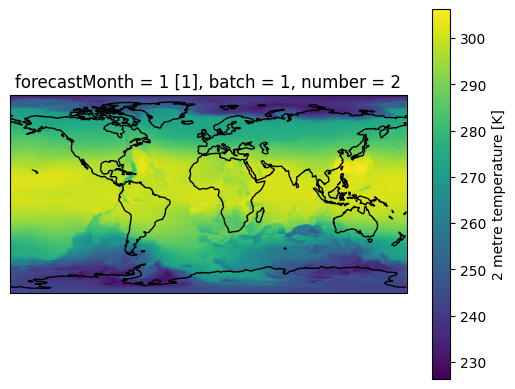

In [14]:
train_targets["2m_temperature"].plot(transform=ccrs.PlateCarree(),subplot_kws={"projection": ccrs.PlateCarree()})
plt.gca().coastlines()

All samples created with sample_file[0] (Feb from Jan init)

In [34]:
sample = run_forward_jitted(
      jax.random.PRNGKey(0),
      train_inputs,
      train_targets,
      train_forcings,
  )

/home/users/achamber/virtual_envs/gencast_env/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/users/achamber/virtual_envs/gencast_env/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


In [36]:
sample

<xarray.Dataset> Size: 3MB
Dimensions:                    (number: 1, batch: 1, lat: 180, lon: 360,
                                level: 2)
Coordinates:
    forecastMonth              int64 8B 1
  * lat                        (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                        (lon) float64 3kB 0.0 1.0 2.0 ... 358.0 359.0
  * batch                      (batch) int64 8B 1
  * number                     (number) int64 8B 2
  * level                      (level) float64 16B 500.0 850.0
Data variables:
    10m_u_component_of_wind    (number, batch, lat, lon) float32 259kB xarray...
    10m_v_component_of_wind    (number, batch, lat, lon) float32 259kB xarray...
    2m_temperature             (number, batch, lat, lon) float32 259kB xarray...
    geopotential               (number, batch, level, lat, lon) float32 518kB xarray_jax.JaxArrayWrapper(Array([[[[[54098.703, 54099.05 , 54100.02 , ..., 54096.984, 54097.66 ,            54098.09 ],           [53920.668, 53935.18 , 53950.06 , ..., 53882.957, 53893.2  ,            53906.41 ],           [54203.41 , 54161.875, 54119.29 , ..., 54321.066, 54283.547,            54244.105],           ...,           [53422.83 , 53409.7  , 53395.996, ..., 53463.504, 53449.633,            53436.31 ],           [54432.47 , 54415.227, 54397.496, ..., 54482.215, 54466.28 ,            54449.85 ],           [54261.074, 54259.348, 54258.234, ..., 54263.312, 54262.5  ,            54262.277]],           [[13380.715, 13379.939, 13379.273, ..., 13384.35 , 13382.863,            13381.72 ],           [13406.344, 13407.187, 13408.898, ..., 13409.745, 13406.504,            13406.076],           [13643.564, 13619.841, 13596.168, ..., 13712.744, 13690.331,            13667.032],           ...,           [13691.722, 13689.179, 13686.391, ..., 13694.852, 13694.207,            13693.01 ],           [13935.519, 13938.03 , 13941.116, ..., 13926.711, 13929.649,            13932.289],           [13758.549, 13759.474, 13760.553, ..., 13754.954, 13756.232,            13757.553]]]]], dtype=float32)...
    mean_sea_level_pressure    (number, batch, lat, lon) float32 259kB xarray...
    temperature                (number, batch, level, lat, lon) float32 518kB xarray_jax.JaxArrayWrapper(Array([[[[[249.98976, 249.97943, 249.9702 , ..., 250.01613, 250.00691,            249.99977],           [252.08983, 252.10295, 252.1116 , ..., 252.03098, 252.04402,            252.071  ],           [251.90692, 251.82082, 251.73105, ..., 252.14949, 252.0736 ,            251.9911 ],           ...,           [246.641  , 246.66116, 246.68106, ..., 246.60046, 246.60883,            246.62256],           [251.95831, 251.96846, 251.97218, ..., 251.90211, 251.92616,            251.94566],           [252.00816, 252.01906, 252.0291 , ..., 251.96104, 251.97816,            251.99155]],           [[280.40143, 280.42294, 280.44534, ..., 280.33273, 280.3558 ,            280.37665],           [284.60706, 284.56387, 284.50894, ..., 284.68564, 284.65762,            284.63812],           [286.7348 , 286.5909 , 286.43768, ..., 287.10294, 286.98776,            286.86493],           ...,           [279.573  , 279.40622, 279.20807, ..., 279.89246, 279.818  ,            279.711  ],           [278.18027, 278.09973, 278.01413, ..., 278.41574, 278.34186,            278.2643 ],           [282.59558, 282.6051 , 282.61063, ..., 282.5709 , 282.58377,            282.58838]]]]], dtype=float32)...
    total_precipitation_month  (number, batch, lat, lon) float32 259kB xarray...
    u_component_of_wind        (number, batch, level, lat, lon) float32 518kB xarray_jax.JaxArrayWrapper(Array([[[[[ 6.6286716 ,  6.6523724 ,  6.675476  , ...,  6.5521245 ,             6.578103  ,  6.6029944 ],           [ 5.7928705 ,  5.9852915 ,  6.1719756 , ...,  5.1687856 ,             5.3983827 ,  5.5968485 ],           [ 3.0240345 ,  3.0250337 ,  3.041108  , ...,  3.108139  ,             3.0637398 ,  3.0359435 ],           ...,           [12.584461  , 12.755743  , 12.929527  

Plots from sample with training loss = 9 (barely trained)

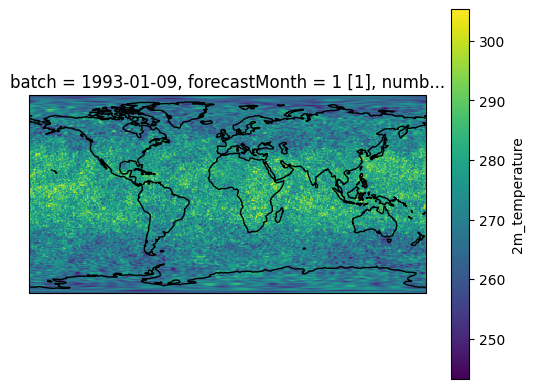

In [50]:
sample["2m_temperature"].plot(transform=ccrs.PlateCarree(),subplot_kws={"projection": ccrs.PlateCarree()})
plt.gca().coastlines()

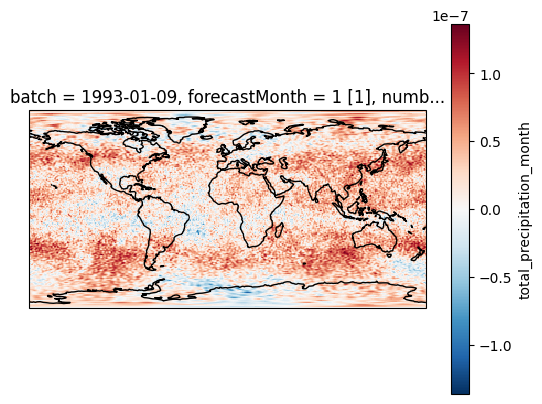

In [51]:
sample["total_precipitation_month"].plot(transform=ccrs.PlateCarree(),subplot_kws={"projection": ccrs.PlateCarree()})
plt.gca().coastlines()

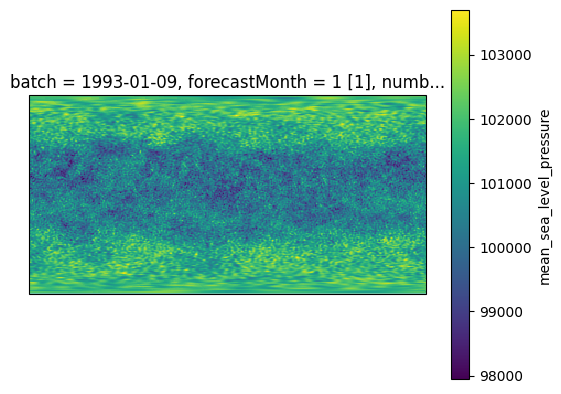

In [52]:
sample["mean_sea_level_pressure"].plot(transform=ccrs.PlateCarree(),subplot_kws={"projection": ccrs.PlateCarree()})


plots from sample with loss~ 6 (5000 iterations, less than a epoch. pmapped with gpu=3 3rd loss higher

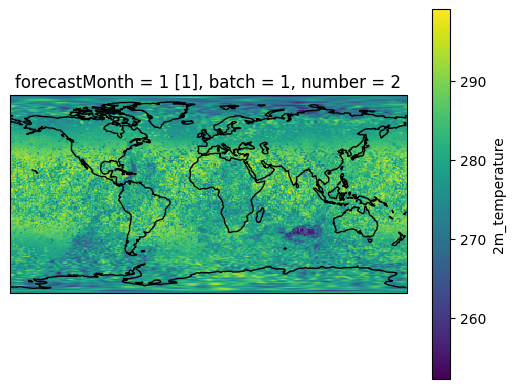

In [37]:
sample["2m_temperature"].plot(transform=ccrs.PlateCarree(),subplot_kws={"projection": ccrs.PlateCarree()})
plt.gca().coastlines()

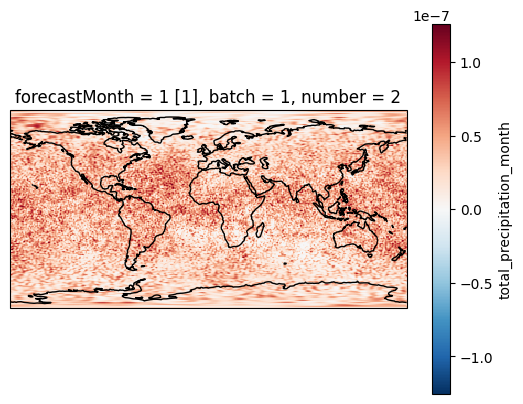

In [38]:
sample["total_precipitation_month"].plot(transform=ccrs.PlateCarree(),subplot_kws={"projection": ccrs.PlateCarree()})
plt.gca().coastlines()

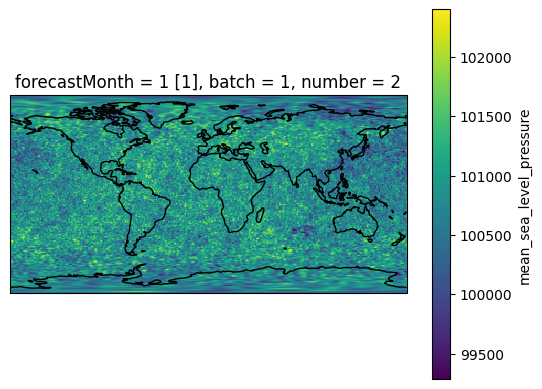

In [39]:
sample["mean_sea_level_pressure"].plot(transform=ccrs.PlateCarree(),subplot_kws={"projection": ccrs.PlateCarree()})
plt.gca().coastlines()